In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [5]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [6]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print('Norm complete')

Norm complete


In [7]:
print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [8]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [9]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


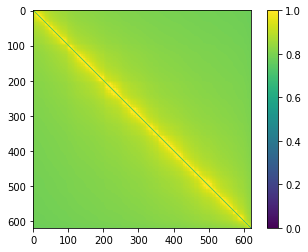

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

def makeEdgeTarget(y):
    e = torch.cdist(y.unsqueeze(1), y.unsqueeze(1))
    e[e == 0] = 1
    e = (1/e)**0.05
    e = mask(e)
    return e

idcs = torch.argsort(age_t)
etgt = makeEdgeTarget(age_t[idcs])

plt.imshow(etgt.detach().cpu())
plt.colorbar()
plt.show()

In [131]:
class InverseSoftmax(nn.Module):
    def __init__(self, e, y):
        super(InverseSoftmax, self).__init__()
        self.e = nn.Parameter(e.detach().clone().float().cuda())
        self.y = y
        
    def forward(self):
        e = mask(self.e)
        e[e == 0] = float('-inf')
        e = F.softmax(e, dim=1)
        return e@self.y, e

mseLoss = torch.nn.MSELoss()
    
grp = 0
    
trainIdcs = groups[grp][0][0:496]
validIdcs = groups[grp][0]
testIdcs = groups[grp][1]

nEpochs = 10000
pPeriod = 200
thresh = 20

etgt = makeEdgeTarget(wrt_t[trainIdcs])

soft = InverseSoftmax(etgt, wrt_t[trainIdcs])
optim = torch.optim.Adam(soft.parameters(), lr=1e-3, weight_decay=1e-3) 

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat, e = soft()
    loss1 = mseLoss(yhat, wrt_t[trainIdcs])
    loss2 = 1e11*mseLoss(e, e.T)
    (loss1+loss2).backward()
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'loss {loss1} {loss2}')
        
print('Complete')

loss 256.15447998046875 234.26235961914062
loss 249.5661163330078 0.02321787178516388
loss 238.26690673828125 0.02462116815149784
loss 224.79933166503906 0.026623720303177834
loss 210.41477966308594 0.029097778722643852
loss 195.92098999023438 0.03187249228358269
loss 181.8116455078125 0.03474143519997597
loss 168.31907653808594 0.03753594681620598
loss 155.52651977539062 0.04016745835542679
loss 143.459716796875 0.04251082241535187
loss 132.13510131835938 0.04443028196692467
loss 121.58687591552734 0.04579857364296913
loss 111.86421966552734 0.04636485502123833
loss 103.01481628417969 0.04612263664603233
loss 95.06607055664062 0.04519273713231087
loss 88.01727294921875 0.04361820966005325
loss 81.9264907836914 0.040794748812913895
loss 76.7986068725586 0.0375327430665493
loss 72.49398803710938 0.034406330436468124
loss 68.86237335205078 0.03132399544119835
loss 65.77862548828125 0.028676016256213188
loss 63.145362854003906 0.025964144617319107
loss 60.889434814453125 0.023926341906189

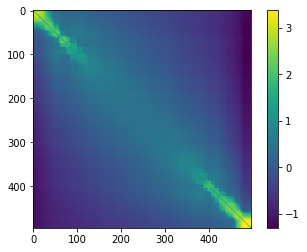

In [133]:
idcs = torch.argsort(wrt_t[trainIdcs])

plt.imshow(soft.e[idcs,:][:,idcs].detach().cpu())
plt.colorbar()
plt.show()

In [254]:
import torch.nn as nn
import torch.nn.functional as F
import time

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

rmse = []

def arith(n):
    return int(n*(n+1)/2)

class LatSim(nn.Module):
    def __init__(self, nTgts, inp, dp=0.5, edp=0.1, wInit=1e-4, dim=2, temp=1):
        super(LatSim, self).__init__()
        self.active = nn.Parameter(wInit*torch.randn(nTgts,inp.shape[-1],dim).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
        self.temp = temp
    
    def getLatentsAndEdges(self, x, i):
        e = 1e-10
        y = torch.einsum('ac,ce->ae', x, self.active[i])
        e = e+y@y.T
        return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        ys = []
        for i in range(self.active.shape[0]):
            _, z, e = self.getLatentsAndEdges(x[:,i,:], i)
            ys.append(z)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = mask(e)
            es.append(e.clone())
            e = self.edp(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e/self.temp, dim=1)
            res.append(e@y)
        return res, es, ys

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss, avg.detach().cpu().numpy()

for grp in range(1):
    egrp = mask(soft.e.detach().clone())
    
    trainIdcs = groups[grp][0][0:496]
    validIdcs = groups[grp][0]
    testIdcs = groups[grp][1]

    X0 = nback_p_t
    X1 = emoid_p_t
    Xreg = torch.stack([X0], dim=1)

    nEpochs = 200
    pPeriod = 5
    thresh = 5

    sim = LatSim(1, Xreg, dp=0.5, edp=0.1, wInit=1e-4, dim=2, temp=5) # 0.2 wrat, 0.1 other
    optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4) 

    Xt = Xreg[trainIdcs]
    Xv = Xreg[validIdcs]

    trainLoss = []
    validLoss = []

    vIdcs1 = np.arange(496,len(validIdcs))
    vIdcs2 = validIdcs[496:]
    vIdcs3 = np.concatenate([testIdcs, vIdcs2])

    var = wrt_t

    for epoch in range(nEpochs):
        optim.zero_grad()
        res, es, ys = sim(Xt, var[trainIdcs])
        avg = torch.mean(torch.stack(res), dim=0)
        loss = 0
        pairLoss = 0
        bigLoss = 0
        for r,y in zip(res + [avg], ys + [ys[0]]):
            loss += mseLoss(r, var[trainIdcs])
            pairLoss += 1e-10*mseLoss(torch.sum(y**2, dim=1)**0.5, torch.ones(y.shape[0]).float().cuda())
            bigLoss += 1e-10*torch.sum(y**2)
        loss = torch.stack([loss, pairLoss, bigLoss])/(len(res)+1)
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss[0]))} pairLoss={float(pairLoss)} bigLoss={bigLoss}')
            lossV, _ = validate(sim, Xv, var[validIdcs], vIdcs1)
            if len(validLoss) == 0 or lossV < min(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(sim.state_dict(), '../../Work/LatentSim/sim.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break

    print('Finished training')

    sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))
    loss, avg = validate(sim, Xreg, var, testIdcs)
    rmse.append(loss)
    
#     yhat[testIdcs] = avg[testIdcs]
    print(f'FINISHED {grp} {loss}')

epoch 0 loss=267.02191162109375 pairLoss=1.8622381687164307 bigLoss=1.6966729410317072e-10
New best validation epoch 0 loss=12.057474136352539
epoch 5 loss=268.9516296386719 pairLoss=3.448004722595215 bigLoss=4.0641143073116837e-07
epoch 10 loss=250.33619689941406 pairLoss=1.3398643732070923 bigLoss=1.763892640838094e-07
New best validation epoch 10 loss=11.903855323791504
epoch 15 loss=195.778076171875 pairLoss=3.086615800857544 bigLoss=3.5697632938536117e-07
epoch 20 loss=163.2310028076172 pairLoss=5.163443088531494 bigLoss=5.229050543675839e-07
epoch 25 loss=118.70660400390625 pairLoss=4.1262030601501465 bigLoss=4.376819902063289e-07
epoch 30 loss=82.7779312133789 pairLoss=3.625096321105957 bigLoss=3.911266333034291e-07
epoch 35 loss=60.28423309326172 pairLoss=3.9976978302001953 bigLoss=4.1240357973038044e-07
epoch 40 loss=40.5025520324707 pairLoss=4.123908519744873 bigLoss=4.2097198615920206e-07
epoch 45 loss=32.043861389160156 pairLoss=4.436811923980713 bigLoss=4.4497363660411793e

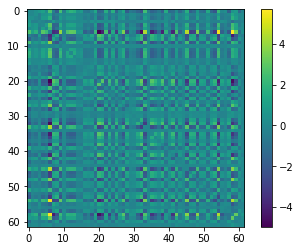

In [189]:
idcs2 = torch.argsort(var[testIdcs])
res, es = sim(Xreg, var)
es[0] = es[0][:,testIdcs]
es[0] = es[0][testIdcs,:]
es[0][es[0] > 10] = 0
es[0][es[0] < -10] = 0
plt.imshow(es[0][idcs2,:][:,idcs2].detach().cpu())
plt.colorbar()
plt.show()

In [139]:
torch.sum(es[0] < -2)

tensor(3774, device='cuda:0')